In [3]:
# Syntax is (for most part) same as NumPy's
import jax.numpy as jnp
import numpy as np

# Special transform functions
from jax import grad, jit, vmap, pmap

# Low level API
# A anagram for XLA, not completely sure how they came up with same JAX
from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

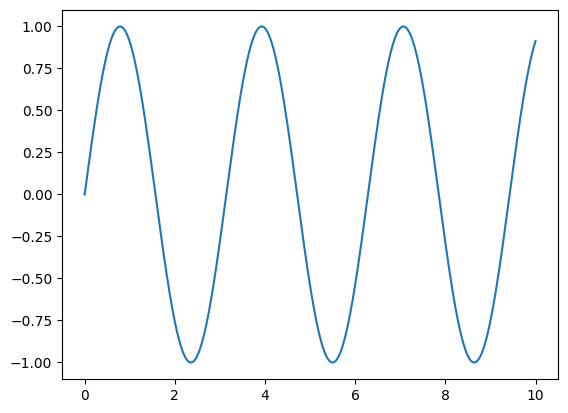

In [4]:
# create a line space (data set)
x_np = jnp.linspace(0,10,1000)
y_np = 2 * jnp.sin(x_np) * jnp.cos(x_np)
plt.plot(x_np, y_np)

In [5]:
# Jax arrays are immutable (embrace the functional programming paradigms )

size = 10 
index = 0
value = 23

# Numpy : mutable arrays
x = np.arange(size)
print(x)
x[index] = value
print(x)

# Jax.numpy : immutable arrays
x = jnp.arange(size)
print(x)
# x[index] = value
# "object does not support item assignment."
# print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]
[0 1 2 3 4 5 6 7 8 9]


In [6]:
y = x.at[index].set(value)
print(y.dtype)
print(x)
print(y)

int32
[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [7]:
# Jax handle random numbers differently
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key,(10,))
print(type(x),x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [8]:
# Jax is AI accelerator agnostic. Same code runs everywhere

size = 3000

x_jnp = random.normal(key,(size,size), dtype=jnp.float32)
x_np = np.random.normal(size=(size,size)).astype(np.float32)

%timeit jnp.dot(x_jnp,x_jnp.T).block_until_ready()
%timeit np.dot(x_np,x_np.T)
%timeit jnp.dot(x_np,x_np.T).block_until_ready()

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()

88.4 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.8 ms ± 6.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
92.5 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
88.7 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# jit() compile function and using XLA and caches them

def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x,y)
    plt.show()

In [11]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)

# visualize_fn(selu)

data = random.normal(key,(100000,))

print("Non-jit version: ")
%timeit selu(data).block_until_ready()
print("jit version: ")
%timeit selu_jit(data).block_until_ready()

Non-jit version: 
138 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
jit version: 
75.5 µs ± 861 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
# grad()
# Automatic diff
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))
    # return jnp.sum(x ** 2)

x = jnp.arange(3.)
loss = sum_logistic

grad_loss = grad(loss)
print(grad_loss(x))

[0.25       0.19661197 0.10499357]


In [19]:
jnp.eye(len(x))

Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [18]:
def finite_differences(f,x):
    eps = 1e-3
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])

print(finite_differences(loss,x))

[0.24998187 0.1964569  0.10502338]


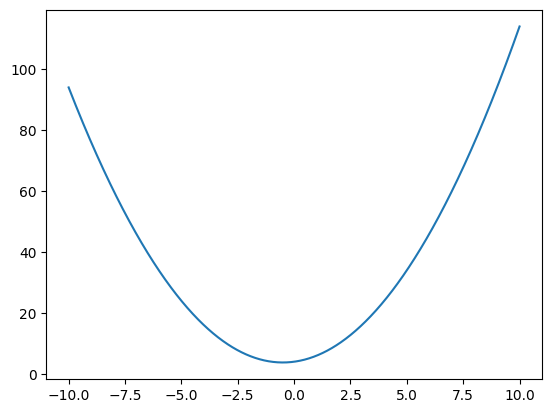

6.0 3.0 2.0 0.0


In [25]:
x = 1.

f = lambda x : x ** 2 + x + 4
visualize_fn(f)

dfdx = grad(f)
d2fdx = grad(dfdx)
d3fdx = grad(d2fdx)

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

In [27]:
x = 1.; y = 1.
h = lambda x, y : x ** 2 + x + 4 + y ** 2
dhdx = grad(h, argnums=(1))
print(h(x, y), dhdx(x,y))

7.0 2.0


In [29]:
from jax import jacfwd, jacrev

f = lambda x, y: x ** 2 + y ** 2

# df / dx = 2x 
# df / dy = 2y 
# J = [df / dy, df / dx]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0,1)),argnums=(0,1)))

print(f'Jacobian = {jacrev(f, argnums=(0,1))(1.,1.)}')
print(f'Full Hession = {hessian(f)(1., 1.)}')

Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hession = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


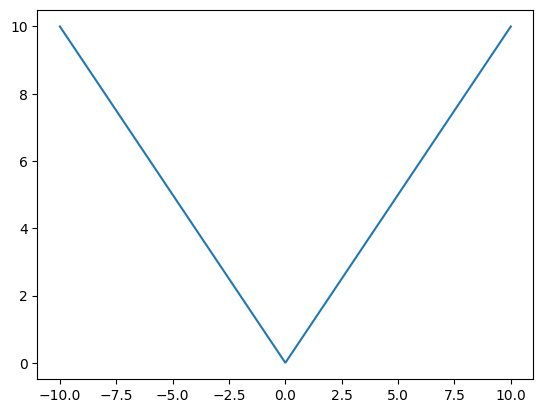

1.0 -1.0


In [33]:
# Edge case |x|, how does JAX handle it?

f = lambda x : abs(x)
visualize_fn(f)

dfdx = grad(f)
print(dfdx(0.), dfdx(-1.))

In [47]:
# vmap()
# function if dealing with a single data point
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(x):
    return jnp.dot(W,x)

In [48]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print("Naively batched")
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
502 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
10.1 µs ± 39.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [52]:
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

print('Autp-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Autp-vectorized with vmap
265 µs ± 779 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
